In [211]:
from __future__ import print_function, division

import os
import time
import PIL

import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt

In [212]:
from torchvision import datasets, models, transforms

data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(64),
        transforms.Resize(64),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        # transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((64, 64), PIL.Image.LANCZOS),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        # transforms.Normalize([0.5], [0.5])
    ]),
}
index_labels = {0: 'WO', 1: ' A', 2: ' I', 3: ' U', 4: ' E', 5: ' O', 6: 'KA', 7: 'KI', 8: 'KU', 9: 'KE', 10: 'KO', 11: 'SA',
                12: 'SI', 13: 'SU', 14: 'SE', 15: 'SO', 16: 'TA', 17: 'TI', 18: 'TU', 19: 'TE', 20: 'TO', 21: 'NA',
                22: 'NI', 23: 'NU', 24: 'NE', 25: 'NO', 26: 'HA', 27: 'HI', 28: 'HU', 29: 'HE', 30: 'HO', 31: 'MA',
                32: 'MI', 33: 'MU', 34: 'ME', 35: 'MO', 36: 'YA', 37: 'YU', 38: 'YO', 39: 'RA', 40: 'RI', 41: 'RU',
                42: 'RE', 43: 'RO', 44: 'WA', 45: ' N'}

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)    
        self.conv2 = nn.Conv2d(64, 64, 3)   
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d()
        self.fc1 = nn.Linear(30 * 30 * 64, 128)
        self.dropout2 = nn.Dropout2d()
        self.fc2 = nn.Linear(128, 46)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 30 * 30 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [5]:
#Ignore this if you already got the weights

data_dir = '/Users/binhna/Downloads/ocr-japanese/citynow_hiragana/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                            shuffle=True, num_workers=4)
            for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def parser():
    parser = argparse.ArgumentParser(description='train hiragana')
    parser.add_argument('--epochs', '-e', type=int, default=2,
                        help='number of epochs to train (default: 2)')
    parser.add_argument('--lr', '-l', type=float, default=0.01,
                        help='learning rate (default: 0.01)')
    args = parser.parse_args()
    return args

def train(epochs= 30, lr= 0.005, momentum= 0.99):

    # create network architecture
    net = Net()

    # define loss function and optimier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, nesterov=True)

    # train
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:
                print('[{:d}, {:5d}] loss: {:.3f}'
                      .format(epoch+1, i+1, running_loss/100))
                running_loss = 0.0
        torch.save(net.state_dict(), 'model.pth')
        torch.save(optimizer.state_dict(), 'optimizer.pth')
    print('Finished Training')

    # test
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for (inputs, labels) in dataloaders['test']:
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy: {:.2f} %'.format(100 * float(correct/total)))

def predict_sample():
    net = Net()
    state_dict = torch.load("model.pth")
    net.load_state_dict(state_dict)
    
    dataiter = iter(dataloaders['train'])
    inputs, labels = dataiter.next()

    with torch.no_grad():
        output = net(inputs)
    
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(inputs[i][0], cmap='gray', interpolation='none')
        plt.title("Prediction:{}-Truth:{}".format(
            output.data.max(1, keepdim=True)[1][i].item(), labels.data[i].item()))
        plt.xticks([])
        plt.yticks([])
    fig
    plt.show()

In [174]:
from matplotlib import pyplot as plt
def showimg(img, title=''):
    plt.imshow(img, cmap='gray')
    if title:
        plt.title(f"{title}")
    plt.show()

def convert_image(img_path):
    bin_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    #image = np.invert(img, dtype=np.uint8)
    #showimg(image)
    #otsu_threshold = 25
    #bin_img = image > otsu_threshold
    #gray_img = (bin_img*255).astype('uint8')
    #showimg(gray_img)
    #bin_img = gray_img//255
    #if bin_img.sum() < img.shape[0]*img.shape[1]*0.4:
    #    return
    
    bin_img = 255 - bin_img
    cv2.imwrite(img_path, bin_img)
    showimg(bin_img)
    #print(bin_img)
    #print(bin_img.shape) 

In [215]:
from PIL import Image
import cv2
from torch.autograd import Variable
# predict some images

net = Net()
net.eval()
state_dict = torch.load('model.pth')
net.load_state_dict(state_dict)

def predict(net, image_path = ''):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    def image_loader(image_name):
        #load image, returns cuda tensor
        loader = data_transforms['test']
        image = Image.open(image_name)
        image = image.convert("RGB")
        #image = image.resize((64, 64))
        print('after reading image', image.size)
        image = loader(image).float()
        #print(image)
        image = Variable(image, requires_grad=False)
        #print(image)
        image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
        print('final size', image.shape)
        return image  #assumes that you're using GPU
    
    image = image_loader(image_path)
    # print(image)
    with torch.no_grad():
        output = net(image)
        #print(output)
    _, predicted = torch.max(output.data, 1)
    showimg(img, index_labels[predicted.item()])
    #print(index_labels[predicted.item()])

after reading image (65, 79)
final size torch.Size([1, 3, 64, 64])


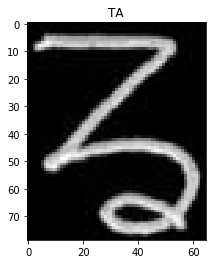

In [217]:
predict(net, '/Users/binhna/Downloads/test/images/ru2.png')

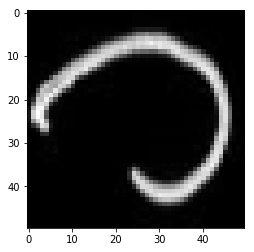

In [203]:
convert_image('/Users/binhna/Downloads/test/images/tsu.png')

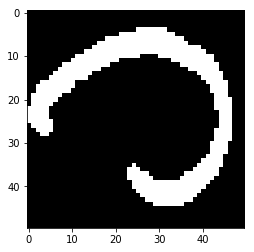

In [208]:
img = cv2.imread('/Users/binhna/Downloads/test/images/tsu.png')
grayscaled = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
th = cv2.adaptiveThreshold(grayscaled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
showimg(th)






In [209]:
img = cv2.imread('/Users/binhna/Downloads/ocr-japanese/citynow_hiragana/data/train/208/d0-1864002c.png')
img.shape

(63, 64, 3)

In [109]:
for param in net.parameters():
  print(param.data)

tensor([[[[-0.1269,  0.0983,  0.0430],
          [ 0.1206, -0.0757,  0.2001],
          [ 0.1660,  0.2001, -0.1955]],

         [[-0.1708, -0.2072, -0.0303],
          [-0.1831, -0.2646,  0.0159],
          [ 0.0616,  0.1312,  0.1153]],

         [[ 0.0635, -0.0310,  0.0244],
          [ 0.0675,  0.0592,  0.0926],
          [ 0.1149, -0.1589, -0.1321]]],


        [[[-0.0393,  0.1677,  0.1404],
          [-0.1349, -0.1112, -0.0239],
          [ 0.0101,  0.0826, -0.1317]],

         [[-0.0087,  0.1548, -0.1371],
          [-0.0151, -0.0795,  0.1215],
          [-0.0303, -0.2299,  0.0409]],

         [[-0.0502,  0.1304,  0.1412],
          [ 0.0512, -0.1318, -0.1544],
          [-0.0654,  0.0776,  0.0835]]],


        [[[-0.1629,  0.1271,  0.0129],
          [ 0.0952,  0.0846, -0.1884],
          [-0.0467, -0.0124,  0.0755]],

         [[-0.0620,  0.1522,  0.0089],
          [ 0.0052,  0.0615, -0.0132],
          [-0.1754,  0.0632,  0.0416]],

         [[-0.0355,  0.1123, -0.1433],
     




# ignore all the below




In [11]:
# old one, ignore it

path_folder = 'data'
x = 'test'
image_test = datasets.ImageFolder(os.path.join(path_folder, x),data_transforms['test'])
dataloaders_test = torch.utils.data.DataLoader(image_test, batch_size=32,
                                            shuffle=False, num_workers=4)

for (inputs, labels) in dataloaders_test:
    # print(inputs)
    with torch.no_grad():
        outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    print(predicted)

'TA'

In [61]:
# ignore all the below

In [67]:
convert_image('/Users/binhna/Downloads/test/images/.png')

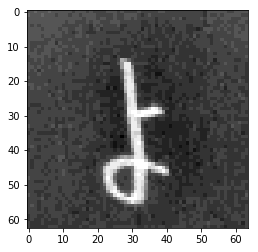

In [58]:
convert_image('/Users/binhna/Downloads/ocr-japanese/citynow_hiragana/data/test/214/d6-1d4c0064.png')